## Imports

In [1]:
# %%
import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

# %%
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




Using device: cuda


## Config

In [ ]:
# %%
@dataclass
class CFG:
    batch_size: int = 64
    num_workers: int = 0
    lr: float = 1e-4
    weight_decay: float = 1e-4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    data_root: str = "data"
    # per-dataset image sizes
    img_size_cifake: int = 32
    img_size_midjourney: int = 64
    img_size_stylegan: int = 128
    # epochs per dataset (you can tune these)
    epochs_cifake: int = 15
    epochs_midjourney: int = 10
    epochs_stylegan: int = 10
    # training tricks
    use_patchmix: bool = True
    patchmix_prob: float = 0.5
    use_adversarial: bool = False   # start False; turn on later if stable
    fgsm_eps: float = 0.01
    pgd_eps: float = 0.03
    pgd_steps: int = 3
    pgd_step_size: float = 0.01
    # loss weights / mixing
    alpha_focal_mix: float = 0.5   # mix between BCE and Focal
    lambda_aux: float = 0.3        # weight for deep supervision aux losses
    # evaluation extras
    do_tsne: bool = True
    tsne_sample: int = 2000
    do_stress_test: bool = True
    # runs per dataset (set >1 if you want mean±std later)
    num_runs: int = 1

cfg = CFG()
cfg

CFG(batch_size=64, num_workers=0, lr=0.0001, weight_decay=0.0001, device='cuda', data_root='data', img_size_cifake=32, img_size_midjourney=64, img_size_stylegan=128, max_dataset_size=10000, epochs_cifake=15, epochs_midjourney=10, epochs_stylegan=10, use_patchmix=True, patchmix_prob=0.5, use_adversarial=False, fgsm_eps=0.01, pgd_eps=0.03, pgd_steps=3, pgd_step_size=0.01, alpha_focal_mix=0.5, lambda_aux=0.3, do_tsne=True, tsne_sample=2000, do_stress_test=True, num_runs=1)

## Forensic Augmentation

In [3]:
# %%
# ----------- Forensic-style data augmentations -----------

class RandomJPEG:
    """Random JPEG-like compression via PIL."""
    def __init__(self, p=0.5, quality_range=(40, 95)):
        self.p = p
        self.quality_range = quality_range

    def __call__(self, img):
        if random.random() >= self.p:
            return img
        q = random.randint(*self.quality_range)
        from io import BytesIO
        from PIL import Image
        buf = BytesIO()
        img.save(buf, format="JPEG", quality=q)
        buf.seek(0)
        img2 = Image.open(buf).convert("RGB")
        return img2


class RandomMotionBlur:
    """Simple 1D motion blur kernel."""
    def __init__(self, p=0.5, kernel_size=7):
        self.p = p
        self.kernel_size = kernel_size
        self.kernel = torch.ones(1, 1, 1, kernel_size) / kernel_size

    def __call__(self, img):
        if random.random() >= self.p:
            return img
        t = TF.to_tensor(img).unsqueeze(0)  # [1,C,H,W]
        kernel = self.kernel.to(t.device)
        out_ch = []
        for c in range(t.shape[1]):
            ch = t[:, c:c+1]
            blurred = torch.nn.functional.conv2d(ch, kernel, padding=(0, self.kernel_size // 2))
            out_ch.append(blurred)
        out = torch.cat(out_ch, dim=1).squeeze(0)
        out = torch.clamp(out, 0.0, 1.0)
        from PIL import Image
        return TF.to_pil_image(out)


def get_train_transform(target_size: int):
    return transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.RandomResizedCrop(target_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        RandomJPEG(p=0.5, quality_range=(40, 95)),
        RandomMotionBlur(p=0.3, kernel_size=7),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)),  # small noise
        transforms.Lambda(lambda x: torch.clamp(x, 0.0, 1.0)),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])


def get_eval_transform(target_size: int):
    return transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])


## Per-Dataset 70/15/15 Split Dataloaders

In [ ]:
# %%
DATA_ROOT = Path(cfg.data_root)

def build_full_dataset(root: str, img_size: int, is_train: bool):
    """
    Build a full dataset from all subfolders under `root` using ImageFolder.
    If root has train/val/test subfolders, we concat them; else we assume root itself has class subdirs.
    """
    base_transform = get_train_transform(img_size) if is_train else get_eval_transform(img_size)
    root_path = Path(root)

    split_dirs = []
    for sub in ["train", "val", "test", "Train", "Val", "Test"]:
        d = root_path / sub
        if d.is_dir():
            split_dirs.append(d)

    if len(split_dirs) == 0:
        ds = datasets.ImageFolder(str(root_path), transform=base_transform)
        full_dataset = ds
        class_names = ds.classes
    else:
        parts = []
        classes = None
        for d in split_dirs:
            ds = datasets.ImageFolder(str(d), transform=base_transform)
            if classes is None:
                classes = ds.classes
            else:
                if ds.classes != classes:
                    raise ValueError(f"Inconsistent classes under {root}")
            parts.append(ds)
        full_dataset = ConcatDataset(parts)
        class_names = classes

    return full_dataset, class_names


def get_dataloaders_for_dataset(ds_root: str, img_size: int, run_seed: int):
    """
    Builds:
    - full dataset (train transform for train split, eval transform for val/test)
    - splits it 70/15/15 for this run
    Returns: train_loader, val_loader, test_loader, class_names
    """
    # build once without transform to get class names / paths
    tmp_ds = datasets.ImageFolder(ds_root) if not any((Path(ds_root)/s).is_dir() for s in ["train","val","test","Train","Val","Test"]) else None

    # first: build full dataset with train transforms, then we will override val/test transforms
    full_train, class_names = build_full_dataset(ds_root, img_size, is_train=True)
    n_total = len(full_train)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    if n_train == 0 or n_val == 0 or n_test == 0:
        raise ValueError(f"Too few samples in {ds_root} for 70/15/15 split. Total={n_total}")

    generator = torch.Generator().manual_seed(run_seed)
    train_ds, val_ds, test_ds = random_split(full_train, [n_train, n_val, n_test], generator=generator)

    # For val/test, override transform with eval transforms
    eval_transform = get_eval_transform(img_size)

    class TransformOverride(torch.utils.data.Dataset):
        def __init__(self, subset, eval_transform):
            self.subset = subset
            self.eval_transform = eval_transform

        def __len__(self):
            return len(self.subset)

        def __getitem__(self, idx):
            img, label = self.subset[idx]
            # img currently has train transform applied; we need original path to re-load.
            # Workaround: assume underlying dataset is ImageFolder and grab original path.
            # ConcatDataset / Subset stack: subset.dataset could be ImageFolder or ConcatDataset.
            # To keep it simple, we build a pure eval dataset separately.
            raise RuntimeError("TransformOverride should not be used this way.")

    # Easier: rebuild eval dataset and slice the same indices
    full_eval, _ = build_full_dataset(ds_root, img_size, is_train=False)
    # random_split indices are in train_ds.indices when underlying is Subset
    train_indices = train_ds.indices if hasattr(train_ds, "indices") else None
    val_indices = val_ds.indices if hasattr(val_ds, "indices") else None
    test_indices = test_ds.indices if hasattr(test_ds, "indices") else None

    train_final = train_ds  # already has train transforms
    val_final = torch.utils.data.Subset(full_eval, val_indices)
    test_final = torch.utils.data.Subset(full_eval, test_indices)

    pin_mem = (cfg.device == "cuda")

    train_loader = DataLoader(train_final, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=pin_mem)
    val_loader = DataLoader(val_final, batch_size=cfg.batch_size, shuffle=False,
                            num_workers=cfg.num_workers, pin_memory=pin_mem)
    test_loader = DataLoader(test_final, batch_size=cfg.batch_size, shuffle=False,
                             num_workers=cfg.num_workers, pin_memory=pin_mem)

    return train_loader, val_loader, test_loader, class_names

# Quick sanity path check (will fail if not present)
for name in ["CIFAKE", "MidJourney", "StyleGAN"]:
    print(name, "->", (DATA_ROOT / name).resolve())


CIFAKE -> E:\University\9th Semester\Deep Learning\PROJECT_Final\data\CIFAKE
MidJourney -> E:\University\9th Semester\Deep Learning\PROJECT_Final\data\MidJourney
StyleGAN -> E:\University\9th Semester\Deep Learning\PROJECT_Final\data\StyleGAN


## Attention Blocks, Color/Frequency Helpers

In [5]:
# %%
# ----------- Attention modules -----------

class SEBlock(nn.Module):
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attn = self.sigmoid(self.conv(x_cat))
        return x * attn

# ----------- Color-space helpers -----------

def torchvision_rgb_to_hsv(img):
    """
    Convert an RGB image tensor to HSV.

    Accepts tensors in shape [B,3,H,W] or [3,H,W] with values in [0,1].
    Returns tensor with same leading batch dims and channels [H,S,V] in ranges H:[0,1], S:[0,1], V:[0,1].
    This provides a fallback for torchvision versions that lack TF.rgb_to_hsv.
    """
    x = img
    squeeze = False
    if x.dim() == 3:
        x = x.unsqueeze(0)
        squeeze = True

    # x: [B,3,H,W]
    r = x[:, 0:1, ...]
    g = x[:, 1:2, ...]
    b = x[:, 2:3, ...]

    maxc, _ = x.max(dim=1, keepdim=True)
    minc, _ = x.min(dim=1, keepdim=True)
    delta = maxc - minc

    eps = 1e-6
    # Value
    v = maxc
    # Saturation
    s = delta / (maxc + eps)

    # Hue computation
    denom = delta + eps
    h_r = (g - b) / denom
    h_g = (b - r) / denom + 2.0
    h_b = (r - g) / denom + 4.0

    h = torch.zeros_like(maxc)
    # masks
    mask = (delta > eps)
    r_mask = (r == maxc) & mask
    g_mask = (g == maxc) & mask
    b_mask = (b == maxc) & mask

    h = torch.where(r_mask, h_r, h)
    h = torch.where(g_mask, h_g, h)
    h = torch.where(b_mask, h_b, h)
    # normalize to [0,1]
    h = (h / 6.0) % 1.0

    hsv = torch.cat([h, s, v], dim=1)
    if squeeze:
        hsv = hsv.squeeze(0)
    return hsv


def rgb_to_ycbcr_torch(x):
    r, g, b = x[:, 0:1], x[:, 1:2], x[:, 2:3]
    y  = 0.299 * r + 0.587 * g + 0.114 * b
    cb = -0.168736 * r - 0.331264 * g + 0.5 * b + 0.5
    cr = 0.5 * r - 0.418688 * g - 0.081312 * b + 0.5
    return torch.cat([y, cb, cr], dim=1)

# ----------- Frequency branch helpers (FFT + DCT) -----------

def dct_1d(x):
    N = x.size(-1)
    v = torch.cat([x, x.flip(dims=[-1])], dim=-1)
    V = torch.fft.fft(v, dim=-1)
    k = torch.arange(N, device=x.device).float()
    w = torch.exp(-1j * np.pi * k / (2 * N))
    D = (V[..., :N] * w).real
    return D

def dct_2d(x):
    x = dct_1d(x.transpose(-1, -2))
    x = dct_1d(x.transpose(-1, -2))
    return x

class SpectralAttention(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // 4),
            nn.ReLU(inplace=True),
            nn.Linear(channels // 4, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, h, w = x.shape
        pooled = x.view(b, c, -1).mean(dim=-1)
        wgt = self.fc(pooled).view(b, c, 1, 1)
        return x * wgt


## Improved ConvBlock, Patch Branch, Color Branch, Freq Branch, Main Model (Per-Dataset)

In [6]:
# %%
class ConvBlockImproved(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_p)
        self.se = SEBlock(out_channels, reduction=16)
        self.spatial = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.conv(x)
        x = self.se(x)
        x = self.spatial(x)
        x = self.pool(x)
        x = self.dropout(x)
        return x


class PatchArtifactBranch(nn.Module):
    def __init__(self, in_channels: int, patch_size: int = 4, embed_dim: int = 128):
        super().__init__()
        self.patch_size = patch_size
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim, embed_dim, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=4, batch_first=True)
        self.proj = None  # will initialize lazily based on spatial dims

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)  # [B,E,H,W]
        E = x.size(1)
        ph = H // self.patch_size
        pw = W // self.patch_size
        x = x[:, :, :ph*self.patch_size, :pw*self.patch_size]
        x = x.view(B, E, ph, self.patch_size, pw, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()  # [B,ph,pw,E,ps,ps]
        x = x.view(B, ph*pw, E * self.patch_size * self.patch_size)

        if self.proj is None:
            self.proj = nn.Linear(x.size(-1), E).to(x.device)
        x = self.proj(x)  # [B,ph*pw,E]

        out, _ = self.attn(x, x, x)
        out = out.mean(dim=1)  # [B,E]
        return out


class ColorBranch(nn.Module):
    def __init__(self, in_channels=3, embed_dim=256):
        super().__init__()
        self.rgb_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.hsv_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.ycbcr_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(128 * 3, embed_dim)

    def forward(self, x):
        # x roughly in [-1,1], bring to [0,1]
        x_01 = (x * 0.5) + 0.5
        hsv = torchvision_rgb_to_hsv(x_01)
        ycbcr = rgb_to_ycbcr_torch(x_01)

        rgb_feat = self.rgb_conv(x_01).view(x.size(0), -1)
        hsv_feat = self.hsv_conv(hsv).view(x.size(0), -1)
        ycbcr_feat = self.ycbcr_conv(ycbcr).view(x.size(0), -1)

        fused = torch.cat([rgb_feat, hsv_feat, ycbcr_feat], dim=1)
        fused = self.fc(fused)
        return fused


class FrequencyBranch(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.spectral_attn = SpectralAttention(channels=2)
        self.fc = nn.Linear(128, embed_dim)

    def forward(self, x):
        x_01 = (x * 0.5) + 0.5
        gray = 0.299 * x_01[:, 0:1] + 0.587 * x_01[:, 1:2] + 0.114 * x_01[:, 2:3]

        fft = torch.fft.fft2(gray)
        mag = torch.abs(fft)

        dct = dct_2d(gray)
        dct_mag = torch.abs(dct)

        freq = torch.cat([mag, dct_mag], dim=1)
        freq = self.spectral_attn(freq)

        feat = self.conv(freq).view(x.size(0), -1)
        feat = self.fc(feat)
        return feat


class ImprovedDetectorPerDataset(nn.Module):
    """
    Improved architecture for per-dataset binary classification (real vs fake).
    """
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            ConvBlockImproved(3, 64),
            ConvBlockImproved(64, 128),
            ConvBlockImproved(128, 256),
            ConvBlockImproved(256, 512),
        )
        self.backbone_pool = nn.AdaptiveAvgPool2d(1)

        self.patch_branch = PatchArtifactBranch(in_channels=512, patch_size=4, embed_dim=128)
        self.color_branch = ColorBranch(in_channels=3, embed_dim=256)
        self.freq_branch = FrequencyBranch(embed_dim=256)

        self.backbone_dim = 512
        self.patch_dim = 128
        self.color_dim = 256
        self.freq_dim = 256
        total_dim = self.backbone_dim + self.patch_dim + self.color_dim + self.freq_dim

        self.fusion_proj = nn.Linear(total_dim, 512)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512, nhead=8, dim_feedforward=1024, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.real_fake_head = nn.Linear(512, 1)  # logits

        # auxiliary heads for deep supervision
        self.aux_backbone = nn.Linear(self.backbone_dim, 1)
        self.aux_patch = nn.Linear(self.patch_dim, 1)
        self.aux_color = nn.Linear(self.color_dim, 1)
        self.aux_freq = nn.Linear(self.freq_dim, 1)

    def forward_features(self, x):
        feat = self.backbone(x)
        pooled = self.backbone_pool(feat).view(x.size(0), -1)
        patch_vec = self.patch_branch(feat)
        color_vec = self.color_branch(x)
        freq_vec = self.freq_branch(x)
        fused = torch.cat([pooled, patch_vec, color_vec, freq_vec], dim=1)
        fused = self.fusion_proj(fused).unsqueeze(1)
        fused = self.transformer(fused)
        fused = fused.squeeze(1)
        return fused, pooled, patch_vec, color_vec, freq_vec

    def forward(self, x):
        fused, pooled, patch_vec, color_vec, freq_vec = self.forward_features(x)
        main_logits = self.real_fake_head(fused).view(-1)
        aux_out = {
            "backbone": self.aux_backbone(pooled).view(-1),
            "patch": self.aux_patch(patch_vec).view(-1),
            "color": self.aux_color(color_vec).view(-1),
            "freq": self.aux_freq(freq_vec).view(-1),
        }
        return main_logits, aux_out


## Losses, PatchMix, Adversarial

In [7]:
# %%
class FocalBCEWithLogitsLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)
        focal_factor = (1 - pt) ** self.gamma
        loss = self.alpha * focal_factor * bce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

def hybrid_bce_focal(logits, targets, alpha_mix: float, focal_alpha=0.25, gamma=2.0):
    bce = nn.BCEWithLogitsLoss()(logits, targets)
    focal = FocalBCEWithLogitsLoss(alpha=focal_alpha, gamma=gamma)(logits, targets)
    return alpha_mix * bce + (1 - alpha_mix) * focal

# ----------- PatchMix -----------

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_ratio = np.sqrt(1.0 - lam)
    cut_w = int(W * cut_ratio)
    cut_h = int(H * cut_ratio)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    return x1, y1, x2, y2

def apply_patchmix(x, y_rf, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    x1, y1, x2, y2 = rand_bbox(x.size(), lam)
    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

    y_rf_mix = lam * y_rf + (1 - lam) * y_rf[index]
    return x, y_rf_mix

# ----------- Adversarial attacks (optional) -----------

def fgsm_attack(model, x, y_rf, eps, alpha_mix):
    x_adv = x.clone().detach().requires_grad_(True)
    main_logits, aux_out = model(x_adv)
    loss_main = hybrid_bce_focal(main_logits, y_rf, alpha_mix=alpha_mix)
    loss_aux = 0.0
    for aux_logits in aux_out.values():
        loss_aux += hybrid_bce_focal(aux_logits, y_rf, alpha_mix=alpha_mix)
    loss = loss_main + cfg.lambda_aux * (loss_aux / len(aux_out))
    loss.backward()
    grad = x_adv.grad.data
    x_adv = x_adv + eps * grad.sign()
    x_adv = torch.clamp(x_adv, -1.0, 1.0)
    return x_adv.detach()

def pgd_attack(model, x, y_rf, eps, alpha, steps, alpha_mix):
    x_orig = x.clone().detach()
    x_adv = x_orig.clone().detach()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        main_logits, aux_out = model(x_adv)
        loss_main = hybrid_bce_focal(main_logits, y_rf, alpha_mix=alpha_mix)
        loss_aux = 0.0
        for aux_logits in aux_out.values():
            loss_aux += hybrid_bce_focal(aux_logits, y_rf, alpha_mix=alpha_mix)
        loss = loss_main + cfg.lambda_aux * (loss_aux / len(aux_out))
        loss.backward()
        with torch.no_grad():
            grad = x_adv.grad
            x_adv = x_adv + alpha * grad.sign()
            eta = torch.clamp(x_adv - x_orig, min=-eps, max=eps)
            x_adv = torch.clamp(x_orig + eta, -1.0, 1.0)
    return x_adv.detach()


## Train/Eval (Per-Dataset)

In [8]:
# %%
def train_one_epoch_improved(model, loader, optimizer, device):
    model.train()
    running_loss, correct_rf, total = 0.0, 0, 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(device)
        y_rf = y.float().to(device)   # labels: 0/1 from ImageFolder

        # PatchMix
        if cfg.use_patchmix and random.random() < cfg.patchmix_prob:
            x, y_rf = apply_patchmix(x, y_rf)

        optimizer.zero_grad()
        main_logits, aux_out = model(x)

        loss_main = hybrid_bce_focal(main_logits, y_rf, alpha_mix=cfg.alpha_focal_mix)
        loss_aux = 0.0
        for aux_logits in aux_out.values():
            loss_aux += hybrid_bce_focal(aux_logits, y_rf, alpha_mix=cfg.alpha_focal_mix)
        loss_aux /= len(aux_out)

        loss = loss_main + cfg.lambda_aux * loss_aux
        loss.backward()

        # optional adversarial
        if cfg.use_adversarial:
            adv_x_fgsm = fgsm_attack(model, x, y_rf, eps=cfg.fgsm_eps, alpha_mix=cfg.alpha_focal_mix)
            adv_logits, adv_aux = model(adv_x_fgsm)
            adv_loss_main = hybrid_bce_focal(adv_logits, y_rf, alpha_mix=cfg.alpha_focal_mix)
            adv_loss_aux = 0.0
            for aux_logits in adv_aux.values():
                adv_loss_aux += hybrid_bce_focal(aux_logits, y_rf, alpha_mix=cfg.alpha_focal_mix)
            adv_loss_aux /= len(adv_aux)
            adv_loss = adv_loss_main + cfg.lambda_aux * adv_loss_aux
            adv_loss.backward()

            adv_x_pgd = pgd_attack(
                model, x, y_rf, eps=cfg.pgd_eps, alpha=cfg.pgd_step_size,
                steps=cfg.pgd_steps, alpha_mix=cfg.alpha_focal_mix
            )
            adv_logits2, adv_aux2 = model(adv_x_pgd)
            adv_loss_main2 = hybrid_bce_focal(adv_logits2, y_rf, alpha_mix=cfg.alpha_focal_mix)
            adv_loss_aux2 = 0.0
            for aux_logits in adv_aux2.values():
                adv_loss_aux2 += hybrid_bce_focal(aux_logits, y_rf, alpha_mix=cfg.alpha_focal_mix)
            adv_loss_aux2 /= len(adv_aux2)
            adv_loss2 = adv_loss_main2 + cfg.lambda_aux * adv_loss_aux2
            adv_loss2.backward()

        optimizer.step()

        with torch.no_grad():
            running_loss += loss.item() * x.size(0)
            preds = (torch.sigmoid(main_logits) >= 0.5).long()
            correct_rf += (preds == y_rf.long()).sum().item()
            total += x.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct_rf / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate_improved(model, loader, device):
    model.eval()
    running_loss, correct_rf, total = 0.0, 0, 0

    all_y, all_prob = [], []

    for x, y in tqdm(loader, desc="Evaluating", leave=False):
        x = x.to(device)
        y_rf = y.float().to(device)

        logits, aux_out = model(x)
        loss_main = hybrid_bce_focal(logits, y_rf, alpha_mix=cfg.alpha_focal_mix)
        loss_aux = 0.0
        for aux_logits in aux_out.values():
            loss_aux += hybrid_bce_focal(aux_logits, y_rf, alpha_mix=cfg.alpha_focal_mix)
        loss_aux /= len(aux_out)
        loss = loss_main + cfg.lambda_aux * loss_aux

        running_loss += loss.item() * x.size(0)

        prob = torch.sigmoid(logits)
        preds = (prob >= 0.5).long()
        correct_rf += (preds == y_rf.long()).sum().item()
        total += x.size(0)

        all_y.append(y_rf.cpu().numpy())
        all_prob.append(prob.cpu().numpy())

    all_y = np.concatenate(all_y)
    all_prob = np.concatenate(all_prob)

    epoch_loss = running_loss / total
    epoch_acc = correct_rf / total
    return epoch_loss, epoch_acc, all_y, all_prob


## Main Loop Over Datasets (Training + Metrics)

In [9]:
# %%
from pathlib import Path

# directory to store all improved models
CHECKPOINT_DIR = Path("checkpoints_improved")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATASETS = [
    {
        "name": "CIFAKE",
        "root": str((DATA_ROOT / "CIFAKE").resolve()),
        "img_size": cfg.img_size_cifake,
        "num_epochs": cfg.epochs_cifake,
    },
    {
        "name": "MidJourney",
        "root": str((DATA_ROOT / "MidJourney").resolve()),
        "img_size": cfg.img_size_midjourney,
        "num_epochs": cfg.epochs_midjourney,
    },
    {
        "name": "StyleGAN",
        "root": str((DATA_ROOT / "StyleGAN").resolve()),
        "img_size": cfg.img_size_stylegan,
        "num_epochs": cfg.epochs_stylegan,
    },
]

results_per_dataset = {}

for ds in DATASETS:
    ds_name = ds["name"]
    ds_root = ds["root"]
    img_size = ds["img_size"]
    num_epochs = ds["num_epochs"]

    print("\n" + "=" * 80)
    print(f"DATASET: {ds_name}")
    print(f"ROOT   : {ds_root}")
    print(f"IMG_SZ : {img_size} | EPOCHS: {num_epochs}")
    print("=" * 80)

    run_histories = []
    run_metrics = []

    for run_idx in range(cfg.num_runs):
        print(f"\n---- {ds_name} | Run {run_idx+1}/{cfg.num_runs} ----")
        run_seed = 42 + run_idx
        set_global_seed(run_seed)

        train_loader, val_loader, test_loader, class_names = get_dataloaders_for_dataset(
            ds_root, img_size, run_seed
        )

        model = ImprovedDetectorPerDataset().to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

        # track best validation accuracy for this dataset+run
        best_val_acc = 0.0
        best_ckpt_path = CHECKPOINT_DIR / f"improved_{ds_name.lower()}_run{run_idx+1}.pt"

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            tr_loss, tr_acc = train_one_epoch_improved(model, train_loader, optimizer, device)
            val_loss, val_acc, _, _ = evaluate_improved(model, val_loader, device)

            history["train_loss"].append(tr_loss)
            history["train_acc"].append(tr_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            print(f"Train -> loss={tr_loss:.4f}, acc={tr_acc:.4f}")
            print(f"Val   -> loss={val_loss:.4f}, acc={val_acc:.4f}")

            # --------------------
            # SAVE BEST MODEL HERE
            # --------------------
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(
                    {
                        "model_state": model.state_dict(),
                        "optimizer_state": optimizer.state_dict(),
                        "val_acc": best_val_acc,
                        "epoch": epoch + 1,
                        "dataset": ds_name,
                        "run_idx": run_idx + 1,
                        "class_names": class_names,
                    },
                    best_ckpt_path,
                )
                print(f"  -> New best {ds_name} (run {run_idx+1}) saved to {best_ckpt_path}")

        # load best checkpoint for final test evaluation (optional but cleaner)
        if best_ckpt_path.is_file():
            ckpt = torch.load(best_ckpt_path, map_location=device)
            model.load_state_dict(ckpt["model_state"])
            print(f"\nLoaded best {ds_name} model from {best_ckpt_path} for test evaluation.")

        # final test evaluation
        test_loss, test_acc, y_true, y_prob = evaluate_improved(model, test_loader, device)
        y_pred = (y_prob >= 0.5).astype(int)

        print(f"\n[{ds_name}] Run {run_idx+1}: Test loss={test_loss:.4f}, acc={test_acc:.4f}")
        print("Classification report:")
        print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

        cm = confusion_matrix(y_true, y_pred)

        run_histories.append(history)
        run_metrics.append({
            "test_loss": test_loss,
            "test_acc": test_acc,
            "cm": cm,
            "model": model,           # best model after reload
            "test_loader": test_loader,
            "y_true": y_true,
            "y_prob": y_prob,
            "class_names": class_names,
            "ckpt_path": str(best_ckpt_path),
        })

    # aggregate over runs (if >1)
    accs = np.array([m["test_acc"] for m in run_metrics])
    mean_acc = accs.mean()
    std_acc = accs.std() if cfg.num_runs > 1 else 0.0

    results_per_dataset[ds_name] = {
        "run_histories": run_histories,
        "run_metrics": run_metrics,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
    }

    print(f"\n[{ds_name}] Test Accuracy over {cfg.num_runs} run(s): {mean_acc*100:.2f} ± {std_acc*100:.2f}%")



DATASET: CIFAKE
ROOT   : E:\University\9th Semester\Deep Learning\PROJECT_Final\data\CIFAKE
IMG_SZ : 32 | EPOCHS: 15

---- CIFAKE | Run 1/1 ----

Epoch 1/15

Epoch 1/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6180
Val   -> loss=nan, acc=0.5053
  -> New best CIFAKE (run 1) saved to checkpoints_improved\improved_cifake_run1.pt

Epoch 2/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6103
Val   -> loss=nan, acc=0.5053

Epoch 3/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6260
Val   -> loss=nan, acc=0.5053

Epoch 4/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6210
Val   -> loss=nan, acc=0.5053

Epoch 5/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6006
Val   -> loss=nan, acc=0.5053

Epoch 6/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6294
Val   -> loss=nan, acc=0.5053

Epoch 7/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6136
Val   -> loss=nan, acc=0.5053

Epoch 8/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.5989
Val   -> loss=nan, acc=0.5053

Epoch 9/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6350
Val   -> loss=nan, acc=0.5053

Epoch 10/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6134
Val   -> loss=nan, acc=0.5053

Epoch 11/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6249
Val   -> loss=nan, acc=0.5053

Epoch 12/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6051
Val   -> loss=nan, acc=0.5053

Epoch 13/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6144
Val   -> loss=nan, acc=0.5053

Epoch 14/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6177
Val   -> loss=nan, acc=0.5053

Epoch 15/15


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=nan, acc=0.6230
Val   -> loss=nan, acc=0.5053

Loaded best CIFAKE model from checkpoints_improved\improved_cifake_run1.pt for test evaluation.


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


[CIFAKE] Run 1: Test loss=nan, acc=0.5047
Classification report:
              precision    recall  f1-score   support

        FAKE       0.50      1.00      0.67       757
        REAL       0.00      0.00      0.00       743

    accuracy                           0.50      1500
   macro avg       0.25      0.50      0.34      1500
weighted avg       0.25      0.50      0.34      1500


[CIFAKE] Test Accuracy over 1 run(s): 50.47 ± 0.00%

DATASET: MidJourney
ROOT   : E:\University\9th Semester\Deep Learning\PROJECT_Final\data\MidJourney
IMG_SZ : 64 | EPOCHS: 10

---- MidJourney | Run 1/1 ----

Epoch 1/10

Epoch 1/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.3644, acc=0.7623
Val   -> loss=0.2679, acc=0.8340
  -> New best MidJourney (run 1) saved to checkpoints_improved\improved_midjourney_run1.pt

Epoch 2/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2920, acc=0.8227
Val   -> loss=0.1820, acc=0.9107
  -> New best MidJourney (run 1) saved to checkpoints_improved\improved_midjourney_run1.pt

Epoch 3/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2842, acc=0.8334
Val   -> loss=0.1407, acc=0.9560
  -> New best MidJourney (run 1) saved to checkpoints_improved\improved_midjourney_run1.pt

Epoch 4/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2647, acc=0.8456
Val   -> loss=0.1162, acc=0.9880
  -> New best MidJourney (run 1) saved to checkpoints_improved\improved_midjourney_run1.pt

Epoch 5/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2239, acc=0.8697
Val   -> loss=0.0645, acc=0.9893
  -> New best MidJourney (run 1) saved to checkpoints_improved\improved_midjourney_run1.pt

Epoch 6/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2548, acc=0.8406
Val   -> loss=0.1009, acc=0.9813

Epoch 7/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2276, acc=0.8527
Val   -> loss=0.1624, acc=0.9087

Epoch 8/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2080, acc=0.8774
Val   -> loss=0.0563, acc=0.9973
  -> New best MidJourney (run 1) saved to checkpoints_improved\improved_midjourney_run1.pt

Epoch 9/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2307, acc=0.8467
Val   -> loss=0.0758, acc=0.9933

Epoch 10/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1994, acc=0.8630
Val   -> loss=0.1232, acc=0.9620

Loaded best MidJourney model from checkpoints_improved\improved_midjourney_run1.pt for test evaluation.


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


[MidJourney] Run 1: Test loss=0.0593, acc=0.9960
Classification report:
              precision    recall  f1-score   support

        fake       0.99      1.00      1.00       717
        real       1.00      0.99      1.00       783

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


[MidJourney] Test Accuracy over 1 run(s): 99.60 ± 0.00%

DATASET: StyleGAN
ROOT   : E:\University\9th Semester\Deep Learning\PROJECT_Final\data\StyleGAN
IMG_SZ : 128 | EPOCHS: 10

---- StyleGAN | Run 1/1 ----

Epoch 1/10

Epoch 1/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.2291, acc=0.8714
Val   -> loss=0.1036, acc=0.9953
  -> New best StyleGAN (run 1) saved to checkpoints_improved\improved_stylegan_run1.pt

Epoch 2/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1609, acc=0.8889
Val   -> loss=0.0632, acc=0.9967
  -> New best StyleGAN (run 1) saved to checkpoints_improved\improved_stylegan_run1.pt

Epoch 3/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1632, acc=0.8809
Val   -> loss=0.0498, acc=0.9980
  -> New best StyleGAN (run 1) saved to checkpoints_improved\improved_stylegan_run1.pt

Epoch 4/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1588, acc=0.8719
Val   -> loss=0.0279, acc=0.9980

Epoch 5/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1353, acc=0.8990
Val   -> loss=0.0206, acc=0.9993
  -> New best StyleGAN (run 1) saved to checkpoints_improved\improved_stylegan_run1.pt

Epoch 6/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1586, acc=0.8550
Val   -> loss=0.0224, acc=0.9980

Epoch 7/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1418, acc=0.8723
Val   -> loss=0.0183, acc=1.0000
  -> New best StyleGAN (run 1) saved to checkpoints_improved\improved_stylegan_run1.pt

Epoch 8/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1199, acc=0.9011
Val   -> loss=0.0177, acc=0.9993

Epoch 9/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1480, acc=0.8503
Val   -> loss=0.0149, acc=1.0000

Epoch 10/10


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Train -> loss=0.1212, acc=0.8841
Val   -> loss=0.0144, acc=1.0000

Loaded best StyleGAN model from checkpoints_improved\improved_stylegan_run1.pt for test evaluation.


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


[StyleGAN] Run 1: Test loss=0.0177, acc=0.9993
Classification report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00       771
        real       1.00      1.00      1.00       729

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


[StyleGAN] Test Accuracy over 1 run(s): 99.93 ± 0.00%


## Plot Curves & Confusion Matrix (Per Dataset)


=== Visualization for CIFAKE ===


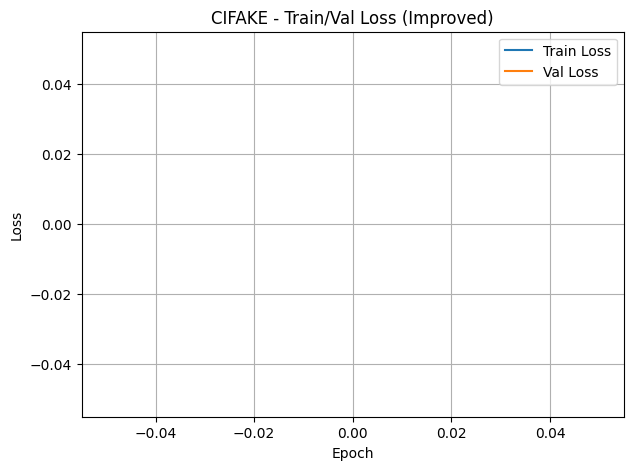

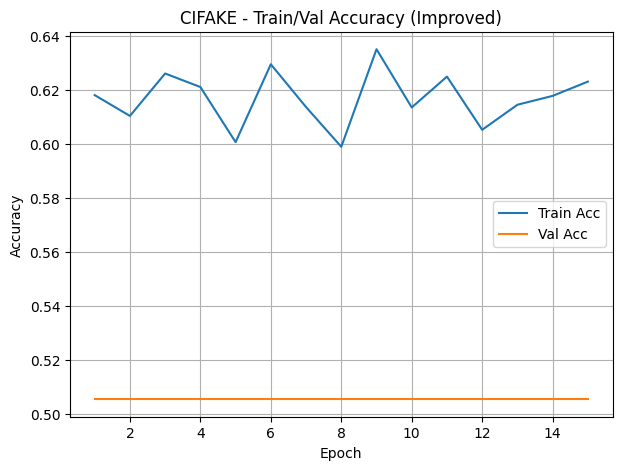

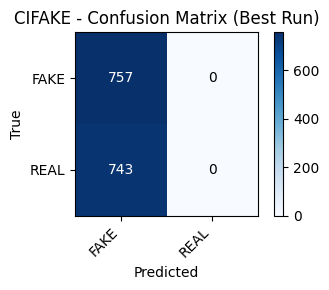


=== Visualization for MidJourney ===


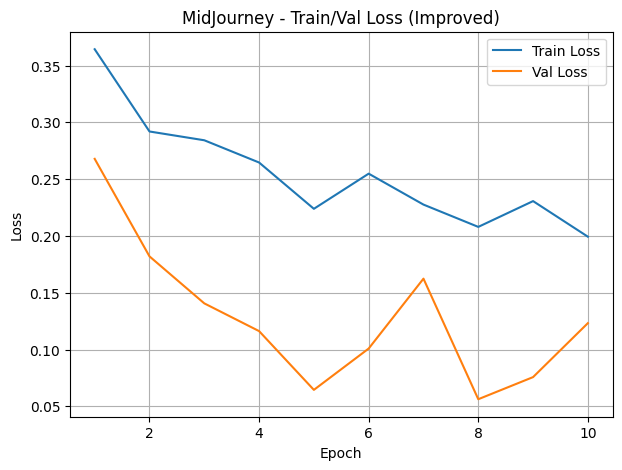

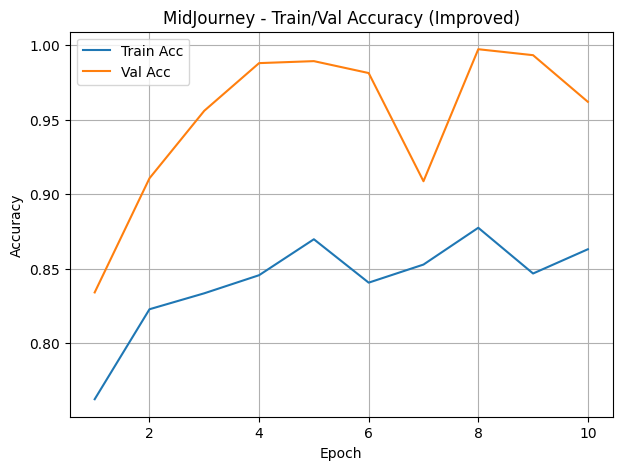

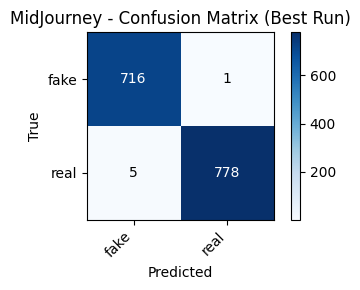


=== Visualization for StyleGAN ===


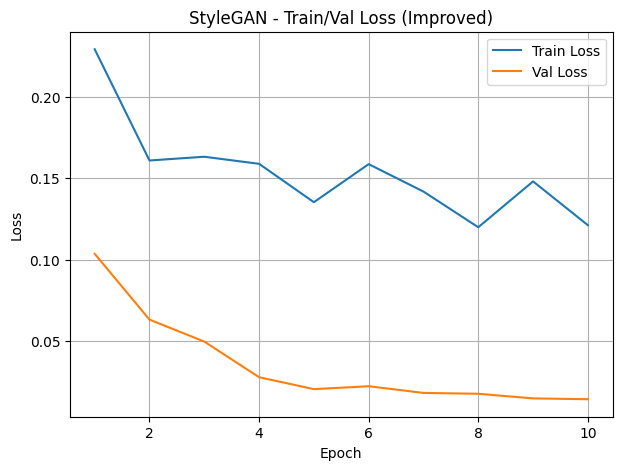

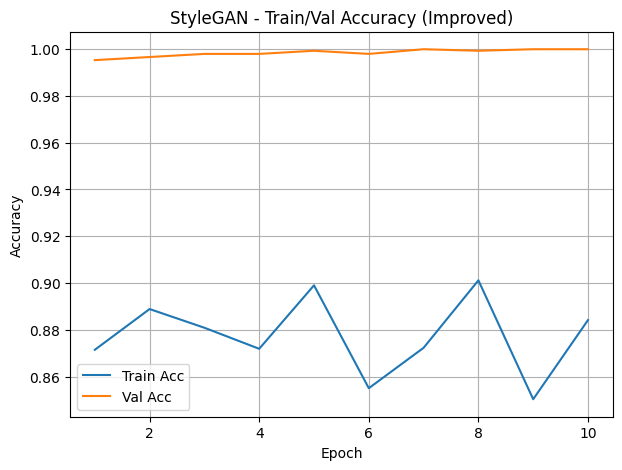

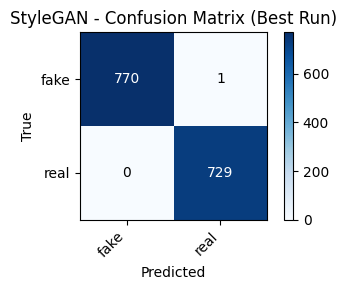

In [10]:
# %%
for ds_name, info in results_per_dataset.items():
    print(f"\n=== Visualization for {ds_name} ===")
    histories = info["run_histories"]
    num_epochs = len(histories[0]["train_loss"])
    epochs = np.arange(1, num_epochs + 1)

    # stack run metrics
    train_loss_all = np.array([h["train_loss"] for h in histories])
    val_loss_all = np.array([h["val_loss"] for h in histories])
    train_acc_all = np.array([h["train_acc"] for h in histories])
    val_acc_all = np.array([h["val_acc"] for h in histories])

    # mean curves
    mean_tr_loss = train_loss_all.mean(axis=0)
    mean_val_loss = val_loss_all.mean(axis=0)
    mean_tr_acc = train_acc_all.mean(axis=0)
    mean_val_acc = val_acc_all.mean(axis=0)

    plt.figure(figsize=(7,5))
    plt.plot(epochs, mean_tr_loss, label="Train Loss")
    plt.plot(epochs, mean_val_loss, label="Val Loss")
    if train_loss_all.shape[0] > 1:
        std_tr_loss = train_loss_all.std(axis=0)
        std_val_loss = val_loss_all.std(axis=0)
        plt.fill_between(epochs, mean_tr_loss - std_tr_loss, mean_tr_loss + std_tr_loss, alpha=0.2)
        plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{ds_name} - Train/Val Loss (Improved)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(epochs, mean_tr_acc, label="Train Acc")
    plt.plot(epochs, mean_val_acc, label="Val Acc")
    if train_acc_all.shape[0] > 1:
        std_tr_acc = train_acc_all.std(axis=0)
        std_val_acc = val_acc_all.std(axis=0)
        plt.fill_between(epochs, mean_tr_acc - std_tr_acc, mean_tr_acc + std_tr_acc, alpha=0.2)
        plt.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{ds_name} - Train/Val Accuracy (Improved)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # confusion matrix from best run
    run_metrics = info["run_metrics"]
    best_idx = int(np.argmax([m["test_acc"] for m in run_metrics]))
    best_run = run_metrics[best_idx]
    cm = best_run["cm"]
    class_names = best_run["class_names"]

    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{ds_name} - Confusion Matrix (Best Run)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


## Save Results

In [11]:
# %%
# Save results and figures for each dataset to disk
import json
import pandas as pd
from pathlib import Path

OUT_FIG_DIR = Path("figures_improved")
OUT_RES_DIR = Path("results_improved")
OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_RES_DIR.mkdir(parents=True, exist_ok=True)

summary_rows = []

for ds_name, info in results_per_dataset.items():
    print(f"Saving results for {ds_name}...")
    ds_fig_dir = OUT_FIG_DIR / ds_name
    ds_fig_dir.mkdir(parents=True, exist_ok=True)

    histories = info.get("run_histories", [])
    run_metrics = info.get("run_metrics", [])

    # Save per-epoch mean curves (recreate plots and save)
    try:
        num_epochs = len(histories[0]["train_loss"]) if len(histories) > 0 else 0
        if num_epochs > 0:
            epochs = np.arange(1, num_epochs + 1)

            train_loss_all = np.array([h["train_loss"] for h in histories])
            val_loss_all = np.array([h["val_loss"] for h in histories])
            train_acc_all = np.array([h["train_acc"] for h in histories])
            val_acc_all = np.array([h["val_acc"] for h in histories])

            mean_tr_loss = train_loss_all.mean(axis=0)
            mean_val_loss = val_loss_all.mean(axis=0)
            mean_tr_acc = train_acc_all.mean(axis=0)
            mean_val_acc = val_acc_all.mean(axis=0)

            # Loss plot
            plt.figure(figsize=(7,5))
            plt.plot(epochs, mean_tr_loss, label="Train Loss")
            plt.plot(epochs, mean_val_loss, label="Val Loss")
            if train_loss_all.shape[0] > 1:
                std_tr_loss = train_loss_all.std(axis=0)
                std_val_loss = val_loss_all.std(axis=0)
                plt.fill_between(epochs, mean_tr_loss - std_tr_loss, mean_tr_loss + std_tr_loss, alpha=0.2)
                plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.2)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"{ds_name} - Train/Val Loss (Improved)")
            plt.legend()
            plt.grid(True)
            loss_path = ds_fig_dir / f"{ds_name}_loss.png"
            plt.tight_layout()
            plt.savefig(loss_path, dpi=150)
            plt.close()

            # Accuracy plot
            plt.figure(figsize=(7,5))
            plt.plot(epochs, mean_tr_acc, label="Train Acc")
            plt.plot(epochs, mean_val_acc, label="Val Acc")
            if train_acc_all.shape[0] > 1:
                std_tr_acc = train_acc_all.std(axis=0)
                std_val_acc = val_acc_all.std(axis=0)
                plt.fill_between(epochs, mean_tr_acc - std_tr_acc, mean_tr_acc + std_tr_acc, alpha=0.2)
                plt.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.2)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title(f"{ds_name} - Train/Val Accuracy (Improved)")
            plt.legend()
            plt.grid(True)
            acc_path = ds_fig_dir / f"{ds_name}_acc.png"
            plt.tight_layout()
            plt.savefig(acc_path, dpi=150)
            plt.close()
    except Exception as e:
        print(f"Could not save curves for {ds_name}: {e}")

    # Best-run confusion matrix (recreate and save)
    try:
        if len(run_metrics) > 0:
            best_idx = int(np.argmax([m["test_acc"] for m in run_metrics]))
            best_run = run_metrics[best_idx]
            cm = best_run.get("cm")
            class_names = best_run.get("class_names")
            if cm is not None:
                plt.figure(figsize=(4,3))
                plt.imshow(cm, cmap="Blues")
                plt.title(f"{ds_name} - Confusion Matrix (Best Run)")
                plt.colorbar()
                if class_names is None:
                    class_names = [str(i) for i in range(cm.shape[0])]
                tick_marks = np.arange(len(class_names))
                plt.xticks(tick_marks, class_names, rotation=45, ha="right")
                plt.yticks(tick_marks, class_names)
                thresh = cm.max() / 2.0
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                                 color="white" if cm[i, j] > thresh else "black")
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.tight_layout()
                cm_path = ds_fig_dir / f"{ds_name}_confusion_best.png"
                plt.savefig(cm_path, dpi=150)
                plt.close()
    except Exception as e:
        print(f"Could not save confusion for {ds_name}: {e}")

    # t-SNE (recompute and save if enabled) -- may be slow
    try:
        if cfg.do_tsne and len(run_metrics) > 0:
            best_run = max(run_metrics, key=lambda m: m.get("test_acc", 0.0))
            model = best_run.get("model")
            test_loader = best_run.get("test_loader")
            if model is not None and test_loader is not None:
                model.eval()
                feats = []
                labels_rf = []
                with torch.no_grad():
                    for x, y in test_loader:
                        x = x.to(device)
                        y = y.to(device).float()
                        fused, _, _, _, _ = model.forward_features(x)
                        feats.append(fused.cpu().numpy())
                        labels_rf.append(y.cpu().numpy())
                        if len(np.concatenate(labels_rf)) >= cfg.tsne_sample:
                            break
                feats = np.concatenate(feats, axis=0)
                labels_rf = np.concatenate(labels_rf, axis=0)
                if feats.shape[0] > 0:
                    print(f"Computing t-SNE for {ds_name} on {feats.shape[0]} samples (this may take a while)")
                    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, verbose=0)
                    emb = tsne.fit_transform(feats)
                    plt.figure(figsize=(7,5))
                    scatter = plt.scatter(emb[:,0], emb[:,1], c=labels_rf, cmap="coolwarm", alpha=0.7)
                    plt.title(f"{ds_name} - t-SNE: Real vs Fake")
                    plt.colorbar(scatter, ticks=[0,1], label="0=class0,1=class1 (ImageFolder)")
                    plt.grid(True)
                    tsne_path = ds_fig_dir / f"{ds_name}_tsne.png"
                    plt.tight_layout()
                    plt.savefig(tsne_path, dpi=150)
                    plt.close()
    except Exception as e:
        print(f"Could not compute/save t-SNE for {ds_name}: {e}")

    # Save run-level metrics to CSV and JSON
    try:
        rows = []
        for idx, m in enumerate(run_metrics):
            rows.append({
                "dataset": ds_name,
                "run_idx": idx,
                "test_loss": float(m.get("test_loss", np.nan)),
                "test_acc": float(m.get("test_acc", np.nan)),
            })
        df_runs = pd.DataFrame(rows)
        csv_path = OUT_RES_DIR / f"{ds_name}_runs.csv"
        df_runs.to_csv(csv_path, index=False)

        # dataset-level summary
        mean_acc = float(info.get("mean_acc", np.nan))
        std_acc = float(info.get("std_acc", np.nan))
        summary_rows.append({"dataset": ds_name, "mean_acc": mean_acc, "std_acc": std_acc})

        # save a lightweight JSON of run_metrics (non-serializable entries removed)
        simple_metrics = []
        for m in run_metrics:
            simple_metrics.append({k: (v.tolist() if isinstance(v, np.ndarray) else None if k == "model" else (v.tolist() if hasattr(v, 'tolist') else v))
                                   for k, v in m.items() if k not in ("model", "test_loader")})
        json_path = OUT_RES_DIR / f"{ds_name}_runs.json"
        with open(json_path, "w") as fh:
            json.dump(simple_metrics, fh, indent=2)

    except Exception as e:
        print(f"Could not save run metrics for {ds_name}: {e}")

# Save aggregated summary
try:
    df_summary = pd.DataFrame(summary_rows)
    summary_csv = OUT_RES_DIR / "summary_improved.csv"
    df_summary.to_csv(summary_csv, index=False)
    print(f"Saved overall summary to {summary_csv}")
except Exception as e:
    print(f"Could not save overall summary: {e}")

print("Done saving results and figures.")


Saving results for CIFAKE...
Computing t-SNE for CIFAKE on 1500 samples (this may take a while)
Could not compute/save t-SNE for CIFAKE: TSNE.__init__() got an unexpected keyword argument 'n_iter'
Saving results for MidJourney...
Computing t-SNE for CIFAKE on 1500 samples (this may take a while)
Could not compute/save t-SNE for CIFAKE: TSNE.__init__() got an unexpected keyword argument 'n_iter'
Saving results for MidJourney...
Computing t-SNE for MidJourney on 1500 samples (this may take a while)
Could not compute/save t-SNE for MidJourney: TSNE.__init__() got an unexpected keyword argument 'n_iter'
Saving results for StyleGAN...
Computing t-SNE for MidJourney on 1500 samples (this may take a while)
Could not compute/save t-SNE for MidJourney: TSNE.__init__() got an unexpected keyword argument 'n_iter'
Saving results for StyleGAN...
Computing t-SNE for StyleGAN on 1500 samples (this may take a while)
Could not compute/save t-SNE for StyleGAN: TSNE.__init__() got an unexpected keyword a

## Final Test Evaluation + Confusion Matrices

In [ ]:
test_loss, test_rf_acc, test_gen_acc, y_rf_true, y_rf_prob, y_gen_true, y_gen_pred = evaluate_improved(model, test_loader, device)

print(f"\nTEST  Real/Fake: loss={test_loss:.4f} acc={test_rf_acc:.4f}")
print(f"TEST Generator: acc={test_gen_acc:.4f}")

# Real/Fake classification report
y_rf_pred = (y_rf_prob >= 0.5).astype(int)
print("\nReal/Fake Classification Report:")
print(classification_report(y_rf_true, y_rf_pred, target_names=["real","fake"]))

# Real/Fake confusion matrix
cm_rf = confusion_matrix(y_rf_true, y_rf_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm_rf, cmap="Blues")
plt.title("Real/Fake Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["real","fake"])
plt.yticks([0,1], ["real","fake"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm_rf[i,j]), ha="center", va="center", color="white" if cm_rf[i,j] > cm_rf.max()/2 else "black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Generator confusion matrix
cm_gen = confusion_matrix(y_gen_true, y_gen_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm_gen, cmap="Greens")
plt.title("Generator Confusion Matrix")
plt.colorbar()
plt.xticks(range(cfg.num_generators), ["CIFAKE","MJ","StyleGAN"], rotation=45)
plt.yticks(range(cfg.num_generators), ["CIFAKE","MJ","StyleGAN"])
for i in range(cfg.num_generators):
    for j in range(cfg.num_generators):
        plt.text(j, i, str(cm_gen[i,j]), ha="center", va="center", color="white" if cm_gen[i,j] > cm_gen.max()/2 else "black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## t-SNE Feature Visualization (Per Dataset)


=== t-SNE for CIFAKE ===


Extracting features (CIFAKE):   0%|          | 0/24 [00:00<?, ?it/s]

Raw features: (1500, 512)
After NaN/inf filter: 0 samples (dropped 1500)
Too few clean samples for t-SNE, skipping this dataset.

=== t-SNE for MidJourney ===


Extracting features (MidJourney):   0%|          | 0/24 [00:00<?, ?it/s]

Raw features: (1500, 512)
After NaN/inf filter: 1500 samples (dropped 0)
t-SNE on 1500 samples with perplexity 30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.006s...
[t-SNE] Computed neighbors for 1500 samples in 3.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.432726
[t-SNE] Computed neighbors for 1500 samples in 3.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.432726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.831989
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.831989
[t-SNE] KL divergence after 1000 iterations: 0.631321
[t-SNE] KL divergence after 1000 iterations: 0.631321


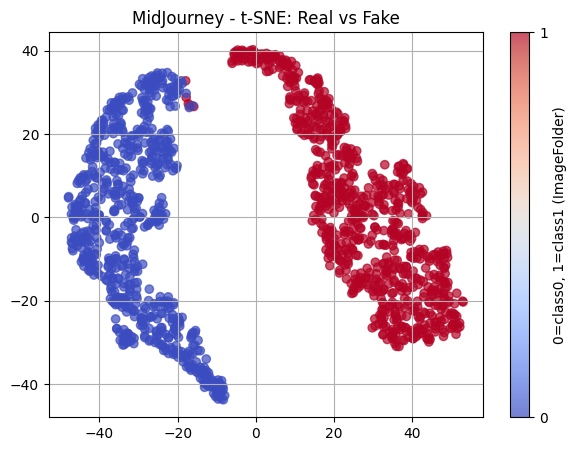


=== t-SNE for StyleGAN ===


Extracting features (StyleGAN):   0%|          | 0/24 [00:00<?, ?it/s]

Raw features: (1500, 512)
After NaN/inf filter: 1500 samples (dropped 0)
t-SNE on 1500 samples with perplexity 30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.424805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.577934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.577934
[t-SNE] KL divergence after 1000 iterations: 0.594182
[t-SNE] KL divergence after 1000 iterations: 0.594182


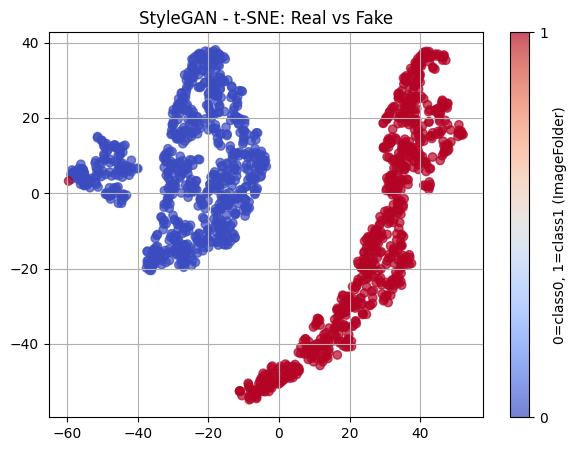

In [20]:
# %%
if cfg.do_tsne:
    for ds_name, info in results_per_dataset.items():
        print(f"\n=== t-SNE for {ds_name} ===")
        best_run = max(info["run_metrics"], key=lambda m: m["test_acc"])
        model = best_run["model"]
        test_loader = best_run["test_loader"]
        class_names = best_run["class_names"]

        model.eval()
        feats = []
        labels_rf = []

        with torch.no_grad():
            for x, y in tqdm(test_loader, desc=f"Extracting features ({ds_name})", leave=False):
                x = x.to(device)
                y = y.to(device).float()
                fused, _, _, _, _ = model.forward_features(x)   # [B, D]
                feats.append(fused.cpu().numpy())
                labels_rf.append(y.cpu().numpy())

                # stop when we've collected enough
                if len(np.concatenate(labels_rf)) >= cfg.tsne_sample:
                    break

        feats = np.concatenate(feats, axis=0)       # [N, D]
        labels_rf = np.concatenate(labels_rf, axis=0)  # [N]

        print("Raw features:", feats.shape)

        # ---------- CLEAN NaN / INF ----------
        mask = np.isfinite(feats).all(axis=1)
        cleaned = feats[mask]
        labels_clean = labels_rf[mask]

        print(f"After NaN/inf filter: {cleaned.shape[0]} samples (dropped {feats.shape[0] - cleaned.shape[0]})")

        # avoid TSNE crash if too few samples or too small vs perplexity
        max_n = min(cfg.tsne_sample, cleaned.shape[0])
        if max_n < 10:
            print("Too few clean samples for t-SNE, skipping this dataset.")
            continue
        if max_n <= 3 * 30:  # 3x perplexity heuristic
            perplexity = max(5, max_n // 3)
        else:
            perplexity = 30

        cleaned = cleaned[:max_n]
        labels_clean = labels_clean[:max_n]

        print("t-SNE on", cleaned.shape[0], "samples with perplexity", perplexity)

        from sklearn.manifold import TSNE
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            learning_rate=200,
            verbose=1,
            init="pca",
        )
        emb = tsne.fit_transform(cleaned)

        plt.figure(figsize=(7, 5))
        scatter = plt.scatter(emb[:, 0], emb[:, 1],
                              c=labels_clean,
                              cmap="coolwarm",
                              alpha=0.7)
        plt.title(f"{ds_name} - t-SNE: Real vs Fake")
        plt.colorbar(scatter, ticks=[0, 1],
                     label="0=class0, 1=class1 (ImageFolder)")
        plt.grid(True)
        plt.show()


## Corruption Stress-Test (Per Dataset)

In [19]:
# %%
def corruption_eval(model, base_loader, corruption_fn, device):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for x, y in tqdm(base_loader, desc="Corruption eval", leave=False):
            x = x.to(device)
            y_rf = y.float().to(device)
            x_corrupt = corruption_fn(x)
            logits, aux_out = model(x_corrupt)
            prob = torch.sigmoid(logits)
            preds = (prob >= 0.5).long()
            correct += (preds == y_rf.long()).sum().item()
            total += x.size(0)
    return correct / total


if cfg.do_stress_test:
    for ds_name, info in results_per_dataset.items():
        print(f"\n=== Stress Test for {ds_name} ===")
        best_run = max(info["run_metrics"], key=lambda m: m["test_acc"])
        model = best_run["model"]
        test_loader = best_run["test_loader"]

        # define corruptions
        def jpeg_like(x):
            noise = torch.randn_like(x) * 0.03
            return torch.clamp(x + noise, -1.0, 1.0)

        def gaussian_noise(x):
            noise = torch.randn_like(x) * 0.05
            return torch.clamp(x + noise, -1.0, 1.0)

        blur_layer = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        def strong_blur(x):
            return blur_layer(x)

        def contrast_shift(x):
            return torch.clamp(1.2 * x, -1.0, 1.0)

        def patch_zero(x):
            B, C, H, W = x.shape
            x_clone = x.clone()
            x1, y1, x2, y2 = rand_bbox(x_clone.size(), lam=0.7)
            x_clone[:, :, y1:y2, x1:x2] = 0.0
            return x_clone

        corruptions = [
            ("JPEG-like", jpeg_like),
            ("GaussianNoise", gaussian_noise),
            ("StrongBlur", strong_blur),
            ("ContrastShift", contrast_shift),
            ("PatchZero", patch_zero),
        ]

        for name, fn in corruptions:
            acc = corruption_eval(model, test_loader, fn, device)
            print(f"{name}: RF acc={acc:.4f}")



=== Stress Test for CIFAKE ===


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

JPEG-like: RF acc=0.5047


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

GaussianNoise: RF acc=0.5047


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

StrongBlur: RF acc=0.5047


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

ContrastShift: RF acc=0.5047


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

PatchZero: RF acc=0.5047

=== Stress Test for MidJourney ===


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

JPEG-like: RF acc=0.9933


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

GaussianNoise: RF acc=0.9867


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

StrongBlur: RF acc=0.7207


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

ContrastShift: RF acc=0.9927


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

PatchZero: RF acc=0.9633

=== Stress Test for StyleGAN ===


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

JPEG-like: RF acc=0.9993


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

GaussianNoise: RF acc=1.0000


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

StrongBlur: RF acc=0.9967


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

ContrastShift: RF acc=0.9993


Corruption eval:   0%|          | 0/24 [00:00<?, ?it/s]

PatchZero: RF acc=0.9980


## Comparison with old Methodology

In [21]:
# %%
# Compare Improved Methodology vs Replication results and save comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print("Preparing comparison between `results/` and `results_improved/`...")

RES_DIR = Path("results")
RES_IMP_DIR = Path("results_improved")
FIG_DIR = Path("figures_improved")
OUT_DIR = RES_IMP_DIR
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# candidates to look for summary CSVs (common names)
orig_candidates = [RES_DIR / "metrics_summary_mean_std.csv", RES_DIR / "baseline_summary.csv", RES_DIR / "summary.csv"]
imp_candidates = [RES_IMP_DIR / "summary_improved.csv", RES_IMP_DIR / "baseline_summary.csv", RES_IMP_DIR / "summary.csv"]


def load_first_existing(candidates):
    for p in candidates:
        if p.exists():
            try:
                df = pd.read_csv(p)
                print(f"Loaded summary from {p}")
                return df, p
            except Exception as e:
                print(f"Found {p} but failed to read: {e}")
    return None, None

orig_df, orig_fp = load_first_existing(orig_candidates)
imp_df, imp_fp = load_first_existing(imp_candidates)

# Fallback: aggregate per-run CSVs if summary not found
def aggregate_runs_from_dir(dpath):
    d = Path(dpath)
    if not d.exists():
        return None
    rows = []
    for f in d.glob("*_runs.csv"):
        try:
            df = pd.read_csv(f)
            if 'test_acc' in df.columns:
                mean_acc = df['test_acc'].mean()
                std_acc = df['test_acc'].std()
                # infer dataset name from filename
                name = f.stem.replace('_runs','')
                rows.append({'dataset': name, 'mean_acc': mean_acc, 'std_acc': std_acc})
        except Exception as e:
            print(f"Skipping {f}: {e}")
    if len(rows) == 0:
        return None
    return pd.DataFrame(rows)

if orig_df is None:
    orig_df = aggregate_runs_from_dir(RES_DIR)
    if orig_df is not None:
        print("Aggregated original results from per-run CSVs.")

if imp_df is None:
    imp_df = aggregate_runs_from_dir(RES_IMP_DIR)
    if imp_df is not None:
        print("Aggregated improved results from per-run CSVs.")

# Normalize column names expected: dataset, mean_acc, std_acc
def normalize(df):
    if df is None:
        return None
    d = df.copy()
    cols = d.columns.str.lower()
    # find mean acc column
    if 'mean_acc' not in d.columns:
        # try common alternatives
        for alt in ['acc_mean','accuracy_mean','mean_accuracy','test_acc_mean']:
            if alt in cols:
                d = d.rename(columns={d.columns[list(cols).index(alt)]: 'mean_acc'})
                break
    if 'std_acc' not in d.columns:
        for alt in ['acc_std','accuracy_std','std_accuracy','test_acc_std']:
            if alt in cols:
                d = d.rename(columns={d.columns[list(cols).index(alt)]: 'std_acc'})
                break
    # ensure dataset column
    if 'dataset' not in d.columns:
        # try first column as dataset
        d = d.rename(columns={d.columns[0]: 'dataset'})
    return d[['dataset','mean_acc','std_acc']].copy()

orig_n = normalize(orig_df)
imp_n = normalize(imp_df)

if orig_n is None and imp_n is None:
    print("No summary data found in either folder. Nothing to compare.")
else:
    # merge on dataset
    if orig_n is None:
        orig_n = pd.DataFrame(columns=['dataset','mean_acc','std_acc'])
    if imp_n is None:
        imp_n = pd.DataFrame(columns=['dataset','mean_acc','std_acc'])

    merged = pd.merge(orig_n, imp_n, on='dataset', how='outer', suffixes=('_orig','_imp'))
    # fill nan with 0 or np.nan maintained for visibility
    merged['mean_acc_orig'] = pd.to_numeric(merged['mean_acc_orig'], errors='coerce')
    merged['std_acc_orig'] = pd.to_numeric(merged['std_acc_orig'], errors='coerce')
    merged['mean_acc_imp'] = pd.to_numeric(merged['mean_acc_imp'], errors='coerce')
    merged['std_acc_imp'] = pd.to_numeric(merged['std_acc_imp'], errors='coerce')

    merged['delta_acc'] = merged['mean_acc_imp'] - merged['mean_acc_orig']
    merged['delta_acc_pct'] = 100.0 * merged['delta_acc'] / (merged['mean_acc_orig'].replace({0:np.nan}))

    # Save merged CSV
    out_csv = OUT_DIR / 'comparison_summary.csv'
    merged.to_csv(out_csv, index=False)
    print(f"Saved comparison CSV to {out_csv}")

    # Plot comparison bar chart
    try:
        datasets = merged['dataset'].astype(str).values
        x = np.arange(len(datasets))
        width = 0.35

        fig, ax = plt.subplots(figsize=(max(6, len(datasets)*1.5), 5))
        ax.bar(x - width/2, merged['mean_acc_orig'].fillna(0), width, yerr=merged['std_acc_orig'].fillna(0), capsize=4, label='Replication')
        ax.bar(x + width/2, merged['mean_acc_imp'].fillna(0), width, yerr=merged['std_acc_imp'].fillna(0), capsize=4, label='Improved')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        ax.set_ylabel('Mean Test Accuracy')
        ax.set_title('Methodology Comparison: Replication vs Improved')
        ax.legend()
        ax.grid(axis='y')
        plt.tight_layout()
        fig_path = FIG_DIR / 'comparison_mean_acc.png'
        fig.savefig(fig_path, dpi=150)
        plt.close(fig)
        print(f"Saved comparison figure to {fig_path}")
    except Exception as e:
        print(f"Could not create/save comparison figure: {e}")

    # Print a small textual summary
    print('\nComparison summary (top lines):')
    display_cols = ['dataset','mean_acc_orig','std_acc_orig','mean_acc_imp','std_acc_imp','delta_acc','delta_acc_pct']
    print(merged[display_cols].fillna('NA').to_string(index=False))

print('Comparison cell finished.')


Preparing comparison between `results/` and `results_improved/`...
Loaded summary from results\metrics_summary_mean_std.csv
Loaded summary from results_improved\summary_improved.csv
Saved comparison CSV to results_improved\comparison_summary.csv
Saved comparison figure to figures_improved\comparison_mean_acc.png

Comparison summary (top lines):
   dataset  mean_acc_orig  std_acc_orig  mean_acc_imp  std_acc_imp  delta_acc  delta_acc_pct
    CIFAKE       0.983250      0.000944      0.504667          0.0  -0.478583     -48.673616
MidJourney       0.999933      0.000067      0.996000          0.0  -0.003933      -0.393360
  StyleGAN       0.999933      0.000067      0.999333          0.0  -0.000600      -0.060004
Comparison cell finished.
